## 1. DATA IMPORT

In [121]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from sklearn.feature_selection import chi2
%matplotlib inline


### We have three csv for now, two are transactional data whereas third is demographic data


In [255]:
df_monthly = pd.read_csv("Visit_Month.csv")
df_demographic = pd.read_csv("Customer_Demographic.csv")
df_transactional = pd.read_csv("Customer_Transaction_Total.csv")
df_customer_churn = pd.read_csv("customer_churn.csv")
df_customer_name = pd.read_csv("customer_name.csv")
df_yearly_transaction= pd.read_csv("yearly_transaction.csv")

In [123]:
df_monthly.info()
## this csv see|ms fine

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 5 columns):
CustomerKey              18484 non-null int64
AverageVisitPerMonth     18484 non-null int64
AverageSpentEachMonth    18484 non-null float64
TotalVisit               18484 non-null int64
TotalMonth               18484 non-null int64
dtypes: float64(1), int64(4)
memory usage: 722.1 KB


In [124]:
df_transactional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 6 columns):
CustomerKey         18484 non-null int64
TotalOrderNumber    18484 non-null int64
TotalSpent          18484 non-null float64
TotalProfit         18484 non-null float64
TotalTransaction    18484 non-null int64
AverageBasket       18484 non-null int64
dtypes: float64(2), int64(4)
memory usage: 866.5 KB


In [125]:
print(df_demographic.info())
print(df_demographic.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 14 columns):
CustomerKey              18484 non-null int64
Gender                   18484 non-null object
TotalChildren            18484 non-null int64
HouseOwnerFlag           18484 non-null int64
SalesTerritoryRegion     18484 non-null object
SalesTerritoryCountry    18484 non-null object
SalesTerritoryGroup      18484 non-null object
EnglishEducation         18484 non-null object
EnglishOccupation        18484 non-null object
Age                      18484 non-null int64
DateFirstPurchase        18484 non-null object
CommuteDistance          18484 non-null object
NumberCarsOwned          18484 non-null int64
YearlyIncomeBand         18484 non-null object
dtypes: int64(5), object(9)
memory usage: 2.0+ MB
None
   CustomerKey Gender  TotalChildren  HouseOwnerFlag SalesTerritoryRegion  \
0        11000      M              2               1            Australia   
1        11001      M        

In [126]:
print(df_customer_churn.info())
## now churn target creation
churn_date = datetime.datetime.strptime('2013-05-31 00:00:00.000','%Y-%m-%d %H:%M:%S.%f')
## convert string transaction to datetime
df_customer_churn["LastTransaction"]= df_customer_churn.LastTransaction.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
df_customer_churn["ChurnTarget"] = df_customer_churn.LastTransaction.apply(lambda x: 1 if x<churn_date else 0)

df_customer_churn["ChurnTarget"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 2 columns):
CustomerKey        18484 non-null int64
LastTransaction    18484 non-null object
dtypes: int64(1), object(1)
memory usage: 288.9+ KB
None


0    12973
1     5511
Name: ChurnTarget, dtype: int64

### merge all data 


In [127]:
result1 = df_monthly.join(df_demographic.set_index('CustomerKey'), on='CustomerKey', how='inner')

In [128]:
result2 = result1.join(df_transactional.set_index('CustomerKey'), on='CustomerKey', how='inner')
result3 = result2.join(df_customer_name.set_index('CustomerKey'), on='CustomerKey', how='inner')
result = result3.join(df_customer_churn[['CustomerKey', 'ChurnTarget']].set_index('CustomerKey'), on='CustomerKey', how='inner')

In [129]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 27 columns):
CustomerKey              18484 non-null int64
AverageVisitPerMonth     18484 non-null int64
AverageSpentEachMonth    18484 non-null float64
TotalVisit               18484 non-null int64
TotalMonth               18484 non-null int64
Gender                   18484 non-null object
TotalChildren            18484 non-null int64
HouseOwnerFlag           18484 non-null int64
SalesTerritoryRegion     18484 non-null object
SalesTerritoryCountry    18484 non-null object
SalesTerritoryGroup      18484 non-null object
EnglishEducation         18484 non-null object
EnglishOccupation        18484 non-null object
Age                      18484 non-null int64
DateFirstPurchase        18484 non-null object
CommuteDistance          18484 non-null object
NumberCarsOwned          18484 non-null int64
YearlyIncomeBand         18484 non-null object
TotalOrderNumber         18484 non-null int64
TotalS

### Get 60% of non churner and hold it out. 


In [130]:
result_churners = result[result["ChurnTarget"] == 1]
result_non_churners = result[result["ChurnTarget"] == 0]
result_non_churner_train, result_non_churner_predict  = np.split(result_non_churners, [int(.40*len(result_non_churners))])
training_df = pd.concat([result_churners, result_non_churner_train], axis = 0)

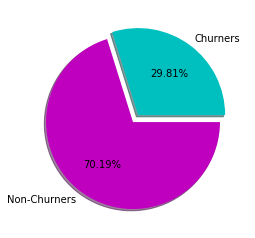

In [11]:
#Exploring before splitting
total_churners,total_non_churners= len(result_churners), len(result_non_churners)
pie_slice = [total_churners, total_non_churners]
labels = ['Churners','Non-Churners' ]
colours = ['c','m']
plt.pie(pie_slice,labels=labels,colors=colours,shadow=True,explode=(0.05,0.05), autopct='%1.2f%%')
plt.show()


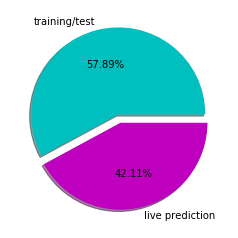

In [12]:
# NOw, we take 60% of non churned data and holdout for live prediction
training_test,hold_out= len(training_df), len(result_non_churner_predict)
pie_slice = [training_test, hold_out]
labels = ['training/test','live prediction' ]
colours = ['c','m']
plt.pie(pie_slice,labels=labels,colors=colours,shadow=True,explode=(0.05,0.05), autopct='%1.2f%%')
plt.show()


In [13]:
training_df.to_csv("training_1.csv")
result_non_churner_predict.to_csv("prediction.csv")

In [14]:
training_df = training_df.drop(['CustomerKey'], axis=1)
result_non_churner_predict= result_non_churner_predict.drop(['CustomerKey'], axis=1)

In [15]:

training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 1 to 7368
Data columns (total 26 columns):
AverageVisitPerMonth     10700 non-null int64
AverageSpentEachMonth    10700 non-null float64
TotalVisit               10700 non-null int64
TotalMonth               10700 non-null int64
Gender                   10700 non-null object
TotalChildren            10700 non-null int64
HouseOwnerFlag           10700 non-null int64
SalesTerritoryRegion     10700 non-null object
SalesTerritoryCountry    10700 non-null object
SalesTerritoryGroup      10700 non-null object
EnglishEducation         10700 non-null object
EnglishOccupation        10700 non-null object
Age                      10700 non-null int64
DateFirstPurchase        10700 non-null object
CommuteDistance          10700 non-null object
NumberCarsOwned          10700 non-null int64
YearlyIncomeBand         10700 non-null object
TotalOrderNumber         10700 non-null int64
TotalSpent               10700 non-null float64
Total

In [16]:
#So, We have 21 columns out of which 1 is target, distinguisg the data into types of data 
Numerical_dataset = ['Age','AverageVisitPerMonth', 'AverageSpentEachMonth', 'TotalVisit','TotalMonth', 'TotalChildren', 'NumberCarsOwned', 'TotalOrderNumber', 'TotalSpent', 'TotalProfit', 'TotalTransaction' , 'AverageBasket' ]
Ordinal_dataset = ['YearlyIncomeBand','CommuteDistance','EnglishEducation']
nominal_dataset = ['Gender', 'HouseOwnerFlag','SalesTerritoryRegion', 'SalesTerritoryCountry','SalesTerritoryGroup', 'EnglishOccupation']

## 2. DATA TRANSFORMATION AND EXPLORATION

### i. Exploring target columns

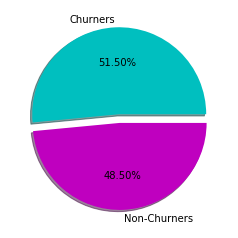

In [17]:
total_data,total_columns = training_df.shape
#Exploring TARGET_B column
target_non_churners,target_churners=training_df.groupby('ChurnTarget').size()
pie_slice = [target_churners, target_non_churners]
labels = ['Churners','Non-Churners' ]
colours = ['c','m']
plt.pie(pie_slice,labels=labels,colors=colours,shadow=True,explode=(0.05,0.05), autopct='%1.2f%%')
plt.show()


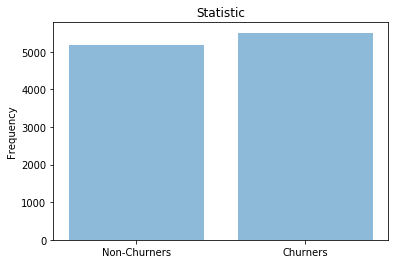

In [18]:
objects = ('Non-Churners', 'Churners')
y_pos = np.arange(len(objects))
performance = [target_non_churners, target_churners]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Statistic')

plt.show()

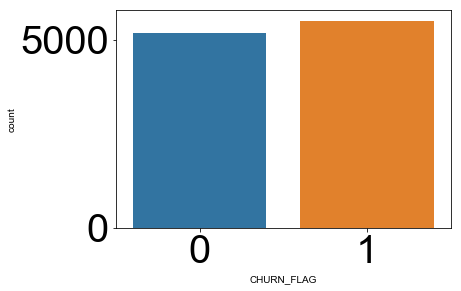

In [19]:

sns.countplot(training_df['ChurnTarget'])
sns.set(rc={'figure.figsize':(50,12)})
plt.xlabel('CHURN_FLAG')
plt.tick_params(labelsize=15)
plt.tick_params(labelsize=40)


In [20]:



training_df[Numerical_dataset].describe()

,Age,AverageVisitPerMonth,AverageSpentEachMonth,TotalVisit,TotalMonth,TotalChildren,NumberCarsOwned,TotalOrderNumber,TotalSpent,TotalProfit,TotalTransaction,AverageBasket
count,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000,10700.000000
mean,51.129065,2.194206,982.276504,3.085047,1.367103,1.827944,1.483551,3.085047,1551.523716,635.432366,1.422336,2.118411
std,11.586937,1.027086,1144.430971,2.295707,0.657129,1.605738,1.127207,2.295707,2053.079613,842.330216,0.923287,0.969917
min,34.000000,1.000000,2.290000,1.000000,1.000000,0.000000,0.000000,1.000000,2.290000,1.433500,1.000000,1.000000
25%,42.000000,1.000000,39.980000,2.000000,1.000000,0.000000,1.000000,2.000000,48.970000,25.033700,1.000000,1.000000
50%,49.000000,2.000000,187.980000,3.000000,1.000000,2.000000,1.000000,3.000000,290.080000,169.315050,1.000000,2.000000
75%,59.000000,3.000000,2049.098200,4.000000,2.000000,3.000000,2.000000,4.000000,2478.340000,1063.072075,2.000000,3.000000
max,103.000000,8.000000,6090.590000,62.000000,11.000000,5.000000,4.000000,62.000000,13295.380000,5273.810000,27.000000,8.000000


### ii. Exploring other columns

#### exploring missing data

In [21]:
missing_data = pd.DataFrame({'total_missing': training_df.isnull().sum(), 'perc_missing': (training_df.isnull().sum()/82790)*100})
missing_data

,perc_missing,total_missing
AverageVisitPerMonth,0.000000,0
AverageSpentEachMonth,0.000000,0
TotalVisit,0.000000,0
TotalMonth,0.000000,0
Gender,0.000000,0
TotalChildren,0.000000,0
HouseOwnerFlag,0.000000,0
SalesTerritoryRegion,0.000000,0
SalesTerritoryCountry,0.000000,0
SalesTerritoryGroup,0.000000,0


In [22]:
def categorical_eda(df):
    """Given dataframe, generate EDA of categorical data"""
    print("To check: Unique count of non-numeric data")
    print(df.select_dtypes(include=['category']).nunique())
    
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df)
        fig.set_xticklabels(rotation=90)
        plt.show()

In [23]:
categorical_eda(training_df)

To check: Unique count of non-numeric data
Series([], dtype: float64)


## BoxPlot of numerical variables

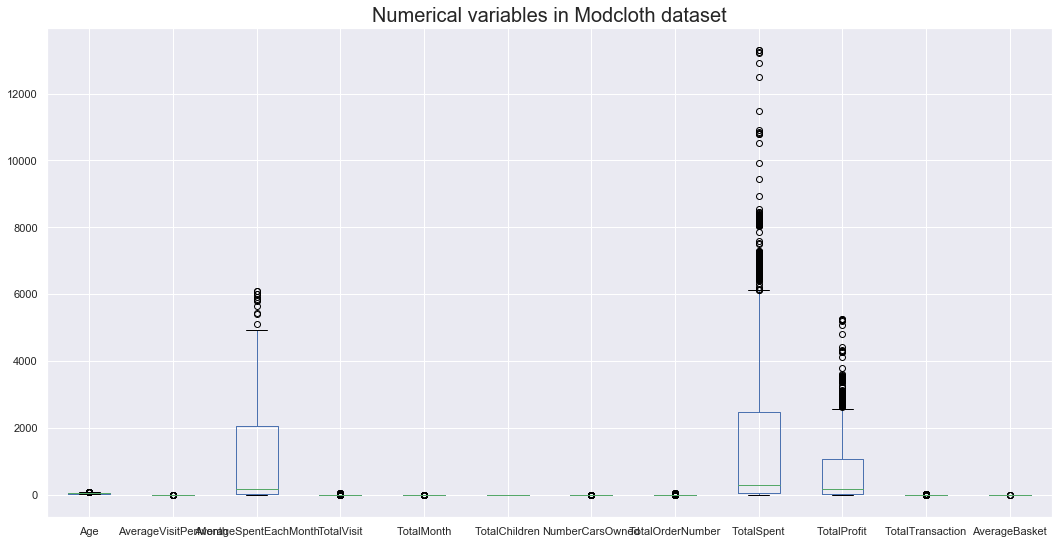

In [24]:

plt.figure(figsize=(18,9))
training_df[Numerical_dataset].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()


Box plot shows outlier to be in total spent and average spent each month and total profit. So, we will remove them here.

In [25]:
training_df = training_df[training_df['TotalSpent']<8000]
training_df = training_df[training_df['AverageSpentEachMonth']<4900]

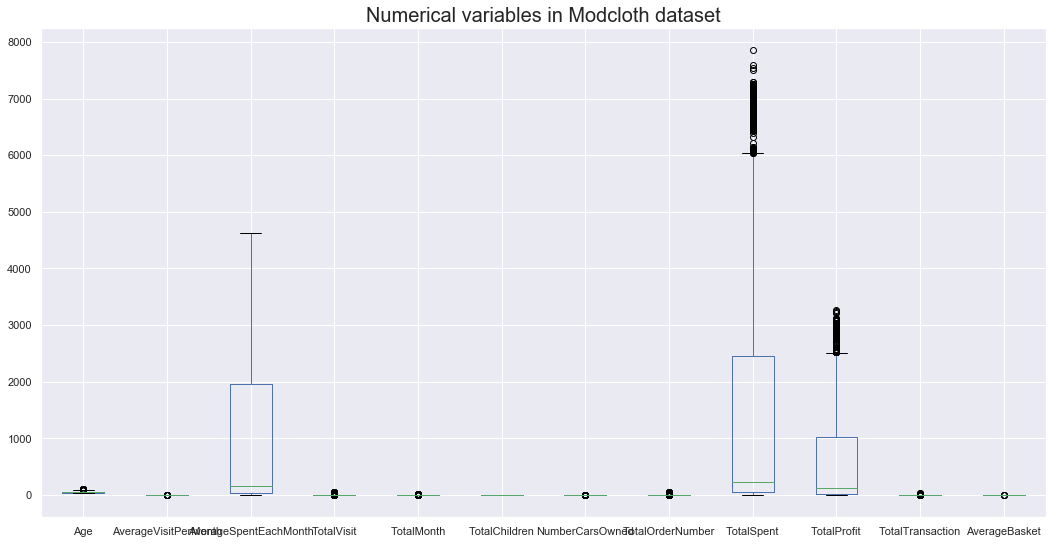

In [26]:

plt.figure(figsize=(18,9))
training_df[Numerical_dataset].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()


In [27]:
# Encoding Nominal dataset

mapper=[{'col': 'YearlyIncomeBand',
          'mapping': {'Below 40k': 1, '40K TO 80K': 2,'80k to 120k': 3, 'Above 120k':4}
        }, {'col': 'CommuteDistance',
          'mapping': {'0-1 Miles': 1, '1-2 Miles': 2,'2-5 Miles': 3, '5-10 Miles':4, '10+ Miles':5}
        },
       {'col': 'EnglishEducation',
          'mapping': {'Partial High School':1, 'High School': 2,'Partial College': 3, 'Bachelors':4,'Graduate Degree':5}
        }]

for each_map in mapper:
    print(each_map)
    # Let's create an object of the class OrdinalEncoder
    ordEncoder = ce.OrdinalEncoder(cols=each_map['col'], mapping=[each_map])

    training_df = ordEncoder.fit_transform(training_df)


    result_non_churner_predict = ordEncoder.fit_transform(result_non_churner_predict)
    

{'mapping': {'Above 120k': 4, '40K TO 80K': 2, 'Below 40k': 1, '80k to 120k': 3}, 'col': 'YearlyIncomeBand'}
{'mapping': {'2-5 Miles': 3, '1-2 Miles': 2, '0-1 Miles': 1, '5-10 Miles': 4, '10+ Miles': 5}, 'col': 'CommuteDistance'}
{'mapping': {'Partial College': 3, 'Bachelors': 4, 'Partial High School': 1, 'High School': 2, 'Graduate Degree': 5}, 'col': 'EnglishEducation'}


In [28]:
training_df

,AverageVisitPerMonth,AverageSpentEachMonth,TotalVisit,TotalMonth,Gender,TotalChildren,HouseOwnerFlag,SalesTerritoryRegion,SalesTerritoryCountry,SalesTerritoryGroup,...,YearlyIncomeBand,TotalOrderNumber,TotalSpent,TotalProfit,TotalTransaction,AverageBasket,FirstName,MiddleName,Lastname,ChurnTarget
1,1,4.9900,1,1,M,2,1,France,France,Europe,...,3,1,4.9900,3.1237,1,1,Edwin,NaN,Kumar,1
4,2,29.4800,2,1,F,1,1,Southeast,United States,North America,...,2,2,29.4800,18.4544,1,2,Pieter,NaN,Wycoff,1
5,1,782.9900,1,1,M,1,1,Canada,Canada,North America,...,2,1,782.9900,296.2834,1,1,Zachary,M,Taylor,1
9,1,2243.2048,3,2,M,1,1,France,France,Europe,...,1,3,4486.4096,2071.6924,2,1,Micah,V,Zhu,1
13,1,21.4900,1,1,F,0,1,Germany,Germany,Europe,...,1,1,21.4900,13.4527,1,1,Cheryl,NaN,Hernandez,1
21,2,37.2900,2,1,M,5,1,Australia,Australia,Pacific,...,2,2,37.2900,23.3435,1,2,Christopher,E,Taylor,1
27,3,2514.2566,9,3,F,2,0,United Kingdom,United Kingdom,Europe,...,4,9,7542.7700,3241.5104,4,2,Mayra,NaN,Prasad,1
31,2,58.9800,2,1,M,1,1,France,France,Europe,...,1,2,58.9800,13.5654,1,2,Willie,D,He,1
45,2,94.4800,2,1,M,0,1,Canada,Canada,North America,...,2,2,94.4800,59.1444,1,2,Joseph,NaN,Robinson,1
50,1,4.9900,1,1,M,0,1,United Kingdom,United Kingdom,Europe,...,1,1,4.9900,3.1237,1,1,Jonathan,A,White,1


In [29]:
# Nominal data encoding
print(nominal_dataset)
for each_datatype in nominal_dataset:
    # Instatniate LabelEncoder
    le = LabelEncoder()# LabelEncode Book_Tablecolumn of df
    training_df[each_datatype] = le.fit_transform(training_df[each_datatype])
    result_non_churner_predict[each_datatype] = le.fit_transform(result_non_churner_predict[each_datatype])

['Gender', 'HouseOwnerFlag', 'SalesTerritoryRegion', 'SalesTerritoryCountry', 'SalesTerritoryGroup', 'EnglishOccupation']


## VISUALIZATION

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def dim_reduc_tsne(arr):
    return TSNE(n_components=3).fit_transform(arr)

def dim_reduc_pca(arr):
    return PCA(n_components=3).fit_transform(arr)


In [31]:
train_x = training_df.drop(columns=['ChurnTarget','DateFirstPurchase', "FirstName", "MiddleName", "Lastname"]).values
cus = training_df.index.tolist()
churn = training_df['ChurnTarget'].tolist()
color = churn
cus_lst = cus
red_arr = dim_reduc_pca(train_x)
df=pd.DataFrame({'X':red_arr[:,0],'Y':red_arr[:,1], 'Z':red_arr[:,2]})
df['Customer'] =  list(range(0, len(cus_lst)))
df['color']=color

In [72]:
import plotly.graph_objs as go
from plotly.offline import plot
data = []
clusters = []
colors = ['rgb(228,26,28)', 'rgb(55,126,184)']  # ,'rgb(77,175,74)']

for i in range(len(df['Customer'].unique())):
    name = df['Customer'].unique()[i]
    #     color = colors[int(df['Customer'].values[0])]
    color = colors[int(df[df['Customer'] == name]['color'].values[0])]
    x = df[df['Customer'] == name]['X']
    y = df[df['Customer'] == name]['Y']
    z = df[df['Customer'] == name]['Z']

    trace = dict(
        name=name,
        x=x, y=y, z=z,
        type="scatter3d",
        mode='markers',
        marker=dict(size=3, color=color, line=dict(width=0)))
    data.append(trace)

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Customer dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio=dict(x=1, y=1, z=0.7),
        aspectmode='manual'
    ),
)

fig = dict(data=data, layout=layout)

# IPython notebook
# py.iplot(fig, filename='pandas-3d-iris', validate=False)

plot(fig, filename='customer_churn.html', validate=False)

'customer_churn.html'

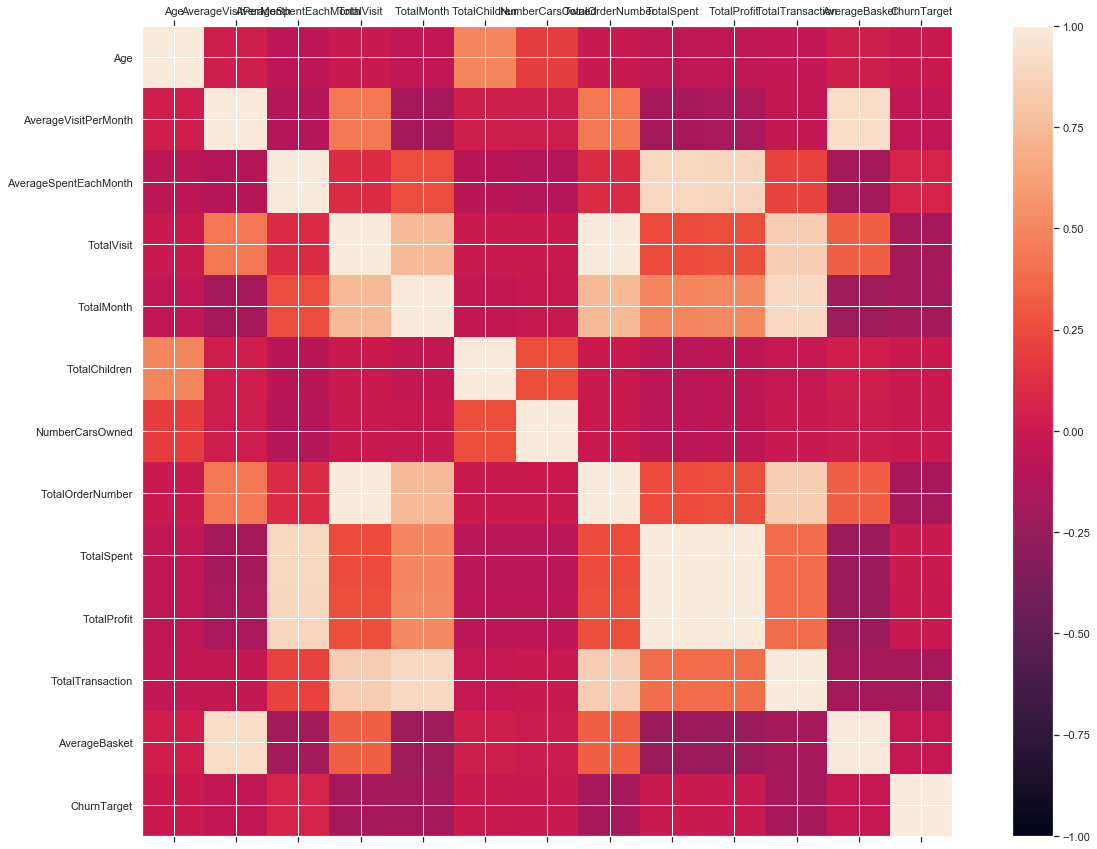

In [32]:
def correlation_matrix(data):
    crln = data.corr()
    fig = plt.figure()
    fig.set_size_inches(18.5, 12.5, forward=True)
    crn_mat = fig.add_subplot(111)
    cax = crn_mat.matshow(crln, vmin=-1, vmax=1)
    plt.subplots_adjust(left=0.1, right=1.0, bottom=0.1, top=1.0)
    fig.colorbar(cax)
    ticks = np.arange(0,len(list(data)),1)
    crn_mat.set_xticks(ticks)
    crn_mat.set_yticks(ticks)
    crn_mat.set_xticklabels(list(data))
    crn_mat.set_yticklabels(list(data))
    plt.show()
correlation_matrix(training_df[Numerical_dataset+ ['ChurnTarget']])

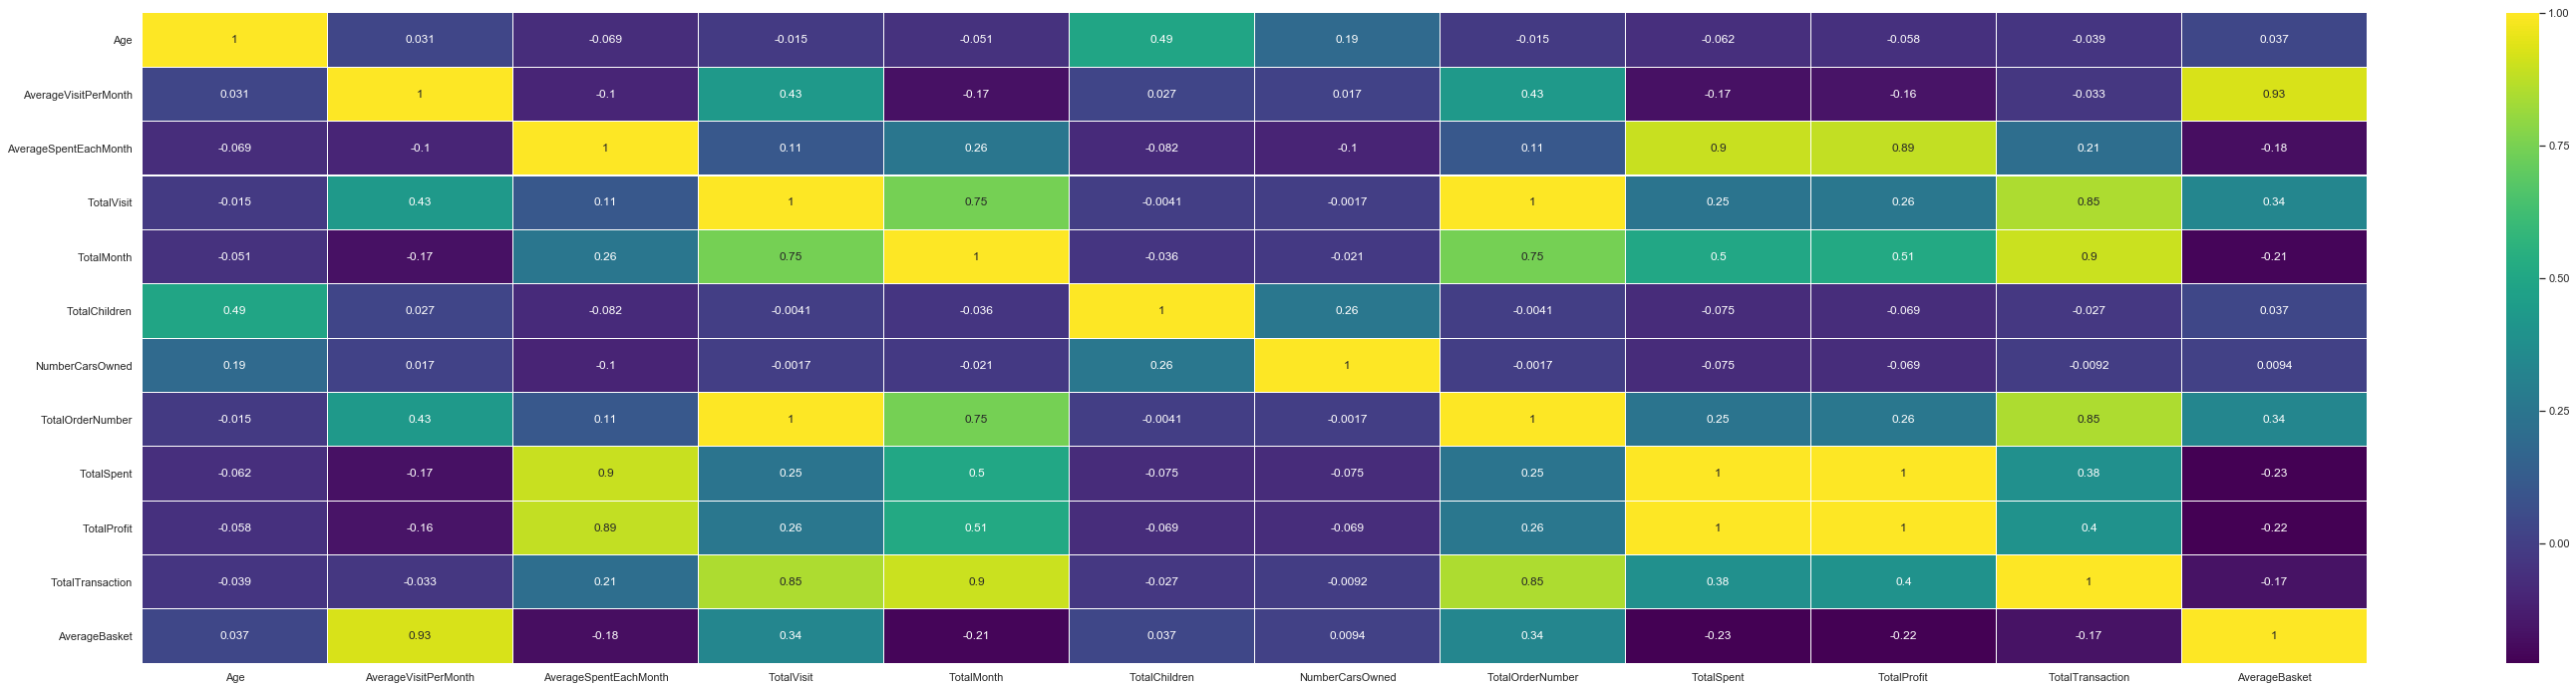

In [33]:
cor=training_df[Numerical_dataset].corr(method='pearson')
# Printing correlation in matrix


# Printing correlation in heat matrix
colormap=plt.cm.viridis

sns.heatmap(cor,cmap=colormap,linewidths=0.1,linecolor='white',annot=True)
plt.show()

In [34]:
cor

,Age,AverageVisitPerMonth,AverageSpentEachMonth,TotalVisit,TotalMonth,TotalChildren,NumberCarsOwned,TotalOrderNumber,TotalSpent,TotalProfit,TotalTransaction,AverageBasket
Age,1.000000,0.030758,-0.068785,-0.015360,-0.050638,0.492540,0.194219,-0.015360,-0.061659,-0.058094,-0.039152,0.036990
AverageVisitPerMonth,0.030758,1.000000,-0.100197,0.433130,-0.170021,0.026513,0.017107,0.433130,-0.170576,-0.163421,-0.032962,0.927239
AverageSpentEachMonth,-0.068785,-0.100197,1.000000,0.108550,0.256253,-0.082212,-0.104397,0.108550,0.898107,0.888807,0.214332,-0.179885
TotalVisit,-0.015360,0.433130,0.108550,1.000000,0.745800,-0.004124,-0.001699,1.000000,0.246729,0.261651,0.848884,0.335592
TotalMonth,-0.050638,-0.170021,0.256253,0.745800,1.000000,-0.035867,-0.020933,0.745800,0.503322,0.513677,0.900131,-0.211509
TotalChildren,0.492540,0.026513,-0.082212,-0.004124,-0.035867,1.000000,0.259768,-0.004124,-0.074776,-0.069073,-0.027175,0.037322
NumberCarsOwned,0.194219,0.017107,-0.104397,-0.001699,-0.020933,0.259768,1.000000,-0.001699,-0.075411,-0.069187,-0.009248,0.009371
TotalOrderNumber,-0.015360,0.433130,0.108550,1.000000,0.745800,-0.004124,-0.001699,1.000000,0.246729,0.261651,0.848884,0.335592
TotalSpent,-0.061659,-0.170576,0.898107,0.246729,0.503322,-0.074776,-0.075411,0.246729,1.000000,0.996822,0.384036,-0.226082
TotalProfit,-0.058094,-0.163421,0.888807,0.261651,0.513677,-0.069073,-0.069187,0.261651,0.996822,1.000000,0.396438,-0.222380


In [35]:
# Now remove one of the two features if there correlation exceeds 0.8 value
columns = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if cor.iloc[i,j] >= 0.5 or cor.iloc[i,j] <= -0.5:
            if columns[j]:
                columns[j] = False



In [36]:
Selected_Numerical_Features = []
for i, each in enumerate(Numerical_dataset):
    if columns[i]:
        Selected_Numerical_Features.append(each)
    else:
        print("Removing " , each)

Removing  TotalMonth
Removing  TotalOrderNumber
Removing  TotalSpent
Removing  TotalProfit
Removing  TotalTransaction
Removing  AverageBasket


In [37]:
Selected_Numerical_Features

['Age',
 'AverageVisitPerMonth',
 'AverageSpentEachMonth',
 'TotalVisit',
 'TotalChildren',
 'NumberCarsOwned']

## Now we do Chi square testing for feature selection of Nominal and Ordinal dataset

In [38]:
X = training_df[nominal_dataset+ Ordinal_dataset]
print(X)
y = training_df['ChurnTarget']

      Gender  HouseOwnerFlag  SalesTerritoryRegion  SalesTerritoryCountry  \
1          1               1                     3                      2   
4          0               1                     7                      5   
5          1               1                     1                      1   
9          1               1                     3                      2   
13         0               1                     4                      3   
21         1               1                     0                      0   
27         0               0                     9                      4   
31         1               1                     3                      2   
45         1               1                     1                      1   
50         1               1                     9                      4   
52         1               1                     3                      2   
53         0               1                     6                      5   

In [39]:
chi_scores = chi2(X,y)

In [40]:
selected_categorical_values = []
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

for i,p_value in p_values.items():
    if p_value> 0.05:
        print("We are removing", i)
    else:
        selected_categorical_values.append(i)
        


We are removing Gender
We are removing EnglishEducation
We are removing CommuteDistance
We are removing HouseOwnerFlag
We are removing SalesTerritoryGroup


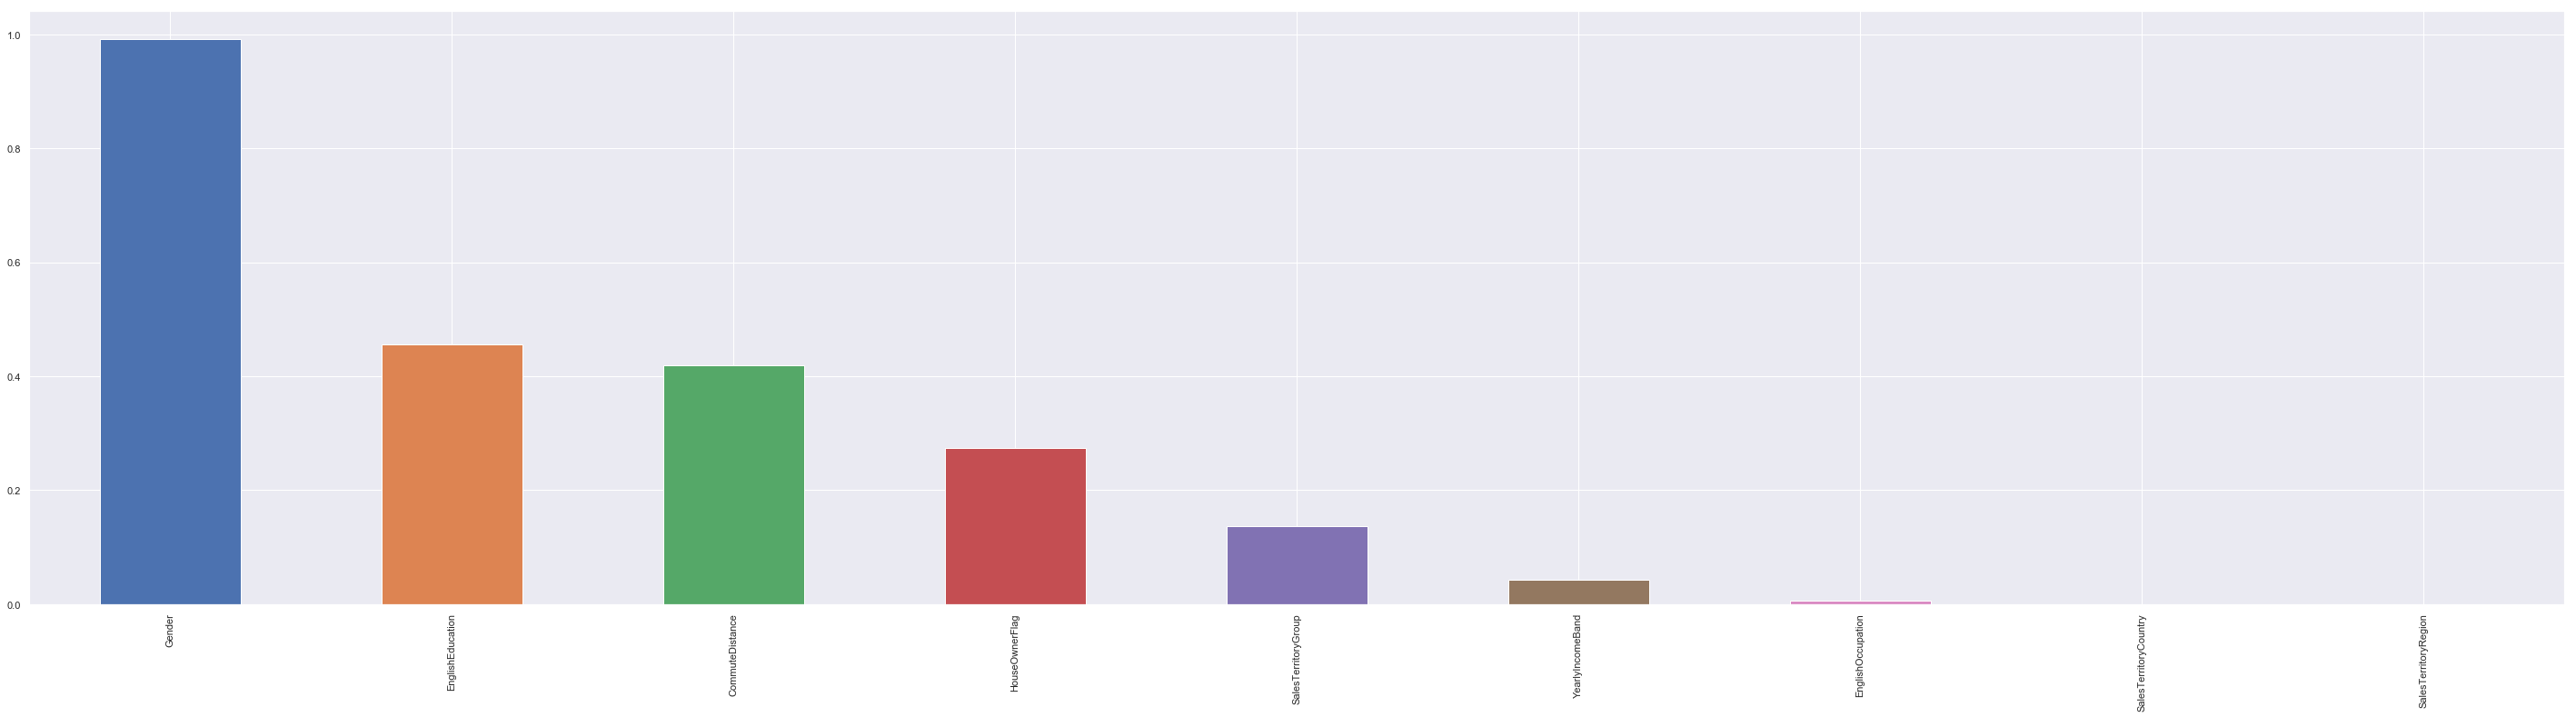

In [41]:
p_values.plot.bar()

In [42]:
selected_features =  Selected_Numerical_Features+selected_categorical_values

In [43]:
print("Selected Features are:", selected_features)

Selected Features are: ['Age', 'AverageVisitPerMonth', 'AverageSpentEachMonth', 'TotalVisit', 'TotalChildren', 'NumberCarsOwned', 'YearlyIncomeBand', 'EnglishOccupation', 'SalesTerritoryCountry', 'SalesTerritoryRegion']


In [44]:
selected_features = [feature for feature in selected_features if feature != 'ChurnTarget']

Since Gender snd Commute distance has higher the p-value, it says that this variables is independent of the churn target and can not be considered for model training

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


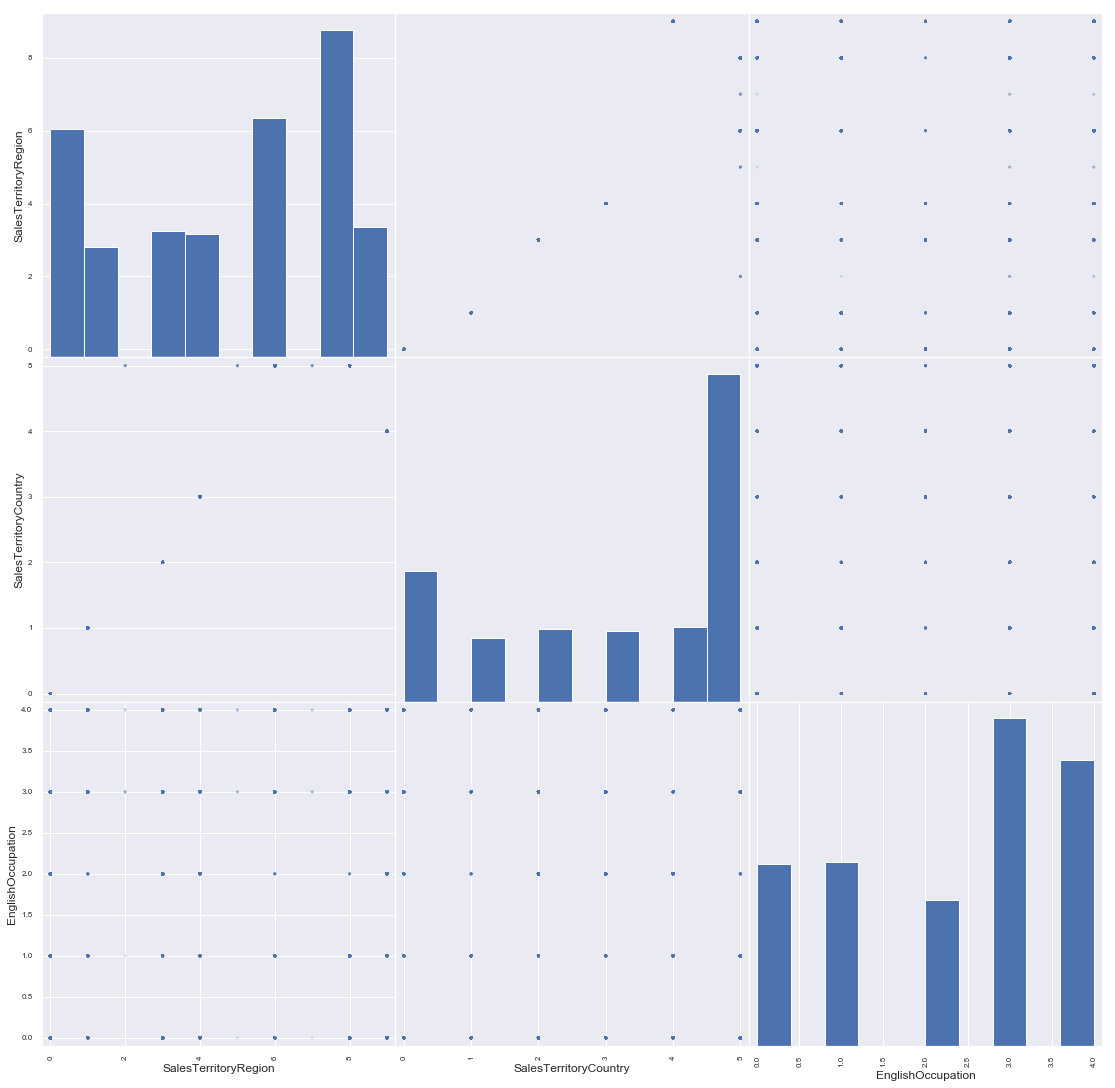

In [45]:
#PLOT SCATTER MATRIX
# using scatter matrix which shows how much one variable affects the other for nominal data only
Nominal_feature_selected = [x for x in nominal_dataset if x in selected_features]
from pandas.tools.plotting import scatter_matrix
def plot_scatter_matrix(data,cols):
    scatter_matrix(data[cols],figsize=(19,19), alpha=0.2)
    plt.show()
columns_for_scatter_matrix= Nominal_feature_selected
plot_scatter_matrix(training_df,columns_for_scatter_matrix)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


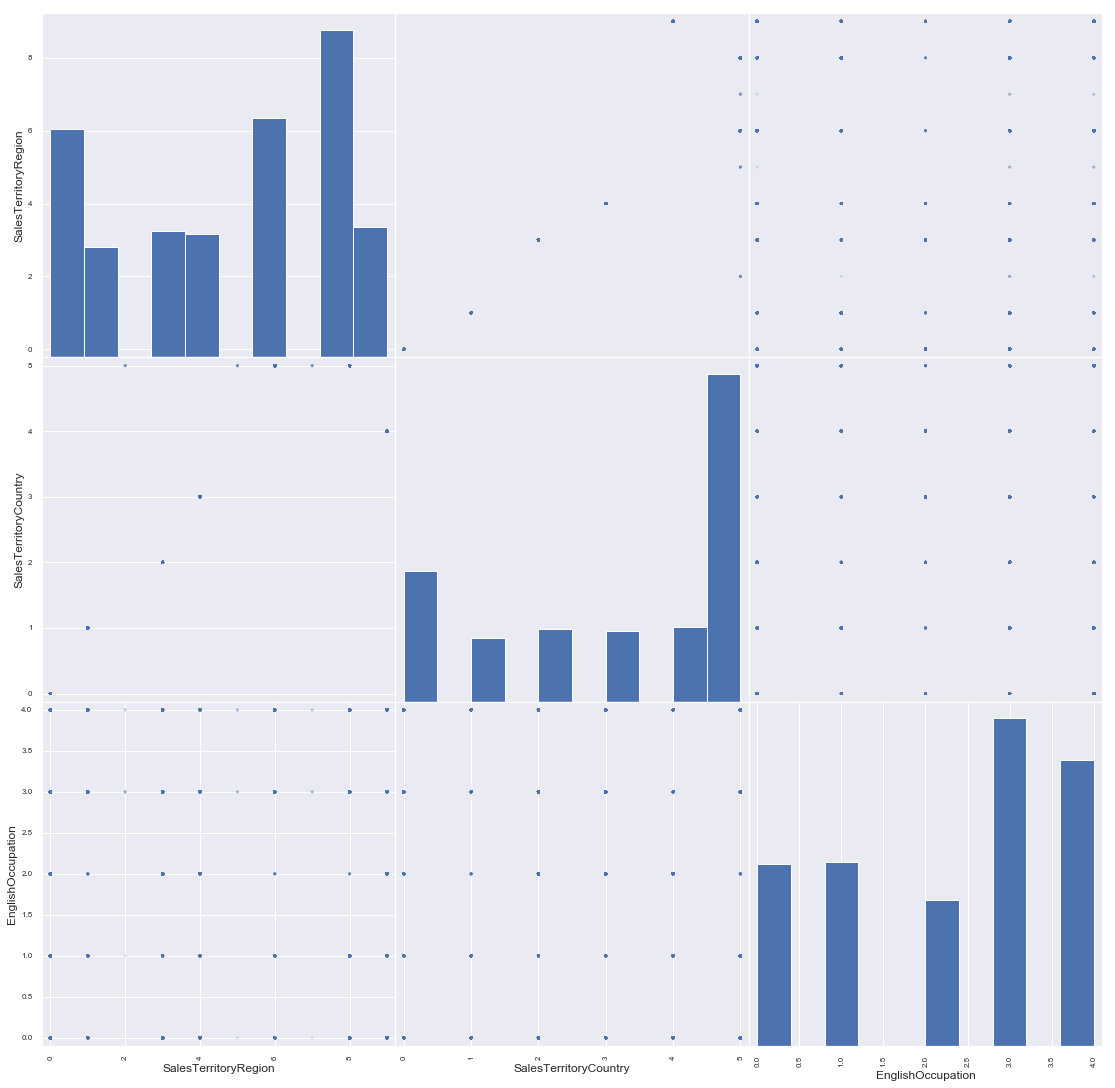

In [46]:
#PLOT SCATTER MATRIX
# using scatter matrix which shows how much one variable affects the other for Ordinal only
Nominal_feature_selected = [x for x in nominal_dataset if x in selected_features]
from pandas.tools.plotting import scatter_matrix
def plot_scatter_matrix(data,cols):
    scatter_matrix(data[cols],figsize=(19,19), alpha=0.2)
    plt.show()
columns_for_scatter_matrix= Nominal_feature_selected
plot_scatter_matrix(training_df,columns_for_scatter_matrix)

In [47]:
training_df = training_df.drop('DateFirstPurchase', axis=1)
result_non_churner_predict = result_non_churner_predict.drop('DateFirstPurchase', axis=1)

In [48]:
training_df= training_df[selected_features + ['ChurnTarget']].drop_duplicates(subset=None, keep='first', inplace=False)
s_df = training_df[selected_features]
print(s_df.columns)
#result_non_churner_predict= result_non_churner_predict[selected_features + ['ChurnTarget']].drop_duplicates(subset=None, keep='first', inplace=False)
s_df_test = result_non_churner_predict[selected_features]

Index(['Age', 'AverageVisitPerMonth', 'AverageSpentEachMonth', 'TotalVisit',
       'TotalChildren', 'NumberCarsOwned', 'YearlyIncomeBand',
       'EnglishOccupation', 'SalesTerritoryCountry', 'SalesTerritoryRegion'],
      dtype='object')


In [49]:
X_train = training_df[selected_features]
y_train = training_df['ChurnTarget']
X_test = result_non_churner_predict[selected_features]
y_test=  result_non_churner_predict['ChurnTarget']

In [50]:
Selected_Numerical_Features

['Age',
 'AverageVisitPerMonth',
 'AverageSpentEachMonth',
 'TotalVisit',
 'TotalChildren',
 'NumberCarsOwned']

In [51]:
from sklearn.preprocessing import StandardScaler
def normalize_data(train_x, test_x):
    scaler = StandardScaler()
    trans_train = train_x.values.reshape([-1,1])
    trans_test = test_x.values.reshape([-1,1])
    scaler = scaler.fit(trans_train)
    result_train = scaler.transform(trans_train)
    print(result_train.shape)
    result_test = scaler.transform(trans_test)
    train = result_train.reshape(-1,1)
    test_test = result_test.reshape( -1,1)
    return train, test_test

In [52]:
for each in selected_features:
    X_train[each], X_test[each] = normalize_data(X_train[each], X_test[each])

/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

(10384, 1)
(10384, 1)
(10384, 1)
(10384, 1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarni

(10384, 1)
(10384, 1)


/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

(10384, 1)
(10384, 1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarni

(10384, 1)
(10384, 1)


/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sharmila/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

## MODEL TRAINING TARGET B

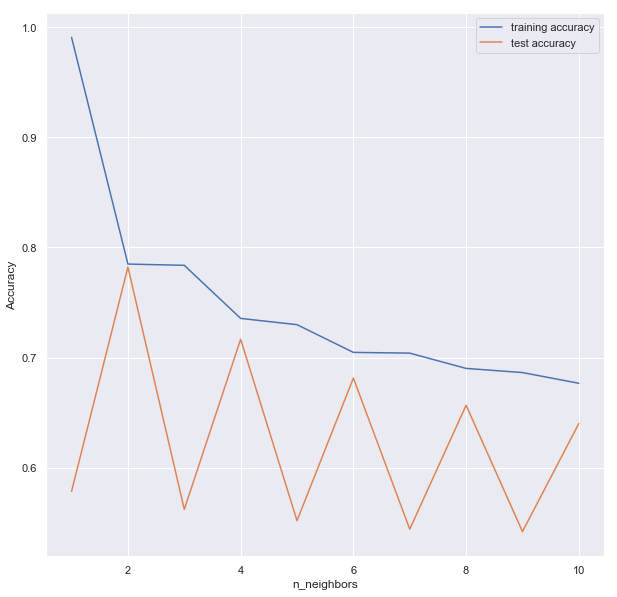

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

# run the model with different hyperparameter settings
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # if accuracy of prediction on training set is high but it is low on test set: So overfitting
    # if accuracy of prediction on training set is low and it is also low on test set: So underfitting
    # predict train set
    train_pred=knn.predict(X_train)
    # predict test set
    test_pred=knn.predict(X_test)
    
    # record training set accuracy
    training_accuracy.append(accuracy_score(y_train, train_pred))
    # record test set accuracy
    test_accuracy.append(accuracy_score(y_test, test_pred))
    
    #training_accuracy.append(knn.score(X_train, y_train))
    #test_accuracy.append(knn.score(X_test, y_test))

plt.figure(figsize=(10,10))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering if we choose one single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using the single nearest neighbor leads to a model that is too complex. The best performance is somewhere around 2 neighbors.

The above plot suggests that we should choose n_neighbors=2. Here we are:


In [56]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
train_pred=knn.predict(X_train)
test_pred=knn.predict(X_test)
print('accuracy of K-NN classifier on training set: {:.2f}'.format(accuracy_score(y_train, train_pred)))
print('accuracy  of K-NN classifier on test set: {:.2f}'.format(accuracy_score(y_test, test_pred)))

accuracy of K-NN classifier on training set: 0.78
accuracy  of K-NN classifier on test set: 0.78


In [57]:
from sklearn.linear_model import LogisticRegression

# Learn from training set
logreg = LogisticRegression(C=1).fit(X_train, y_train) # see https://www.quora.com/What-is-the-C-parameter-in-logistic-regression

# predict train set
train_pred=logreg.predict(X_train)
# predict test set
test_pred=logreg.predict(X_test)

print("Training set accuracy: {:.3f}".format(accuracy_score(y_train, train_pred)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, test_pred)))

Training set accuracy: 0.580
Test set accuracy: 0.402


/home/sharmila/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
logreg001 = LogisticRegression(C=0.01).fit(X_train, y_train) # C is a penalty term, meant to disincentivize and regulate against Overfitting.

# predict train set
train_pred=logreg001.predict(X_train)
# predict test set
test_pred=logreg001.predict(X_test)

print("Training set accuracy: {:.3f}".format(accuracy_score(y_train, train_pred)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, test_pred)))

Training set accuracy: 0.578
Test set accuracy: 0.410


/home/sharmila/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
logreg100 = LogisticRegression(C=100).fit(X_train, y_train)

# predict train set
train_pred=logreg100.predict(X_train)
# predict test set
test_pred=logreg100.predict(X_test)

print("Training set accuracy: {:.3f}".format(accuracy_score(y_train, train_pred)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, test_pred)))

Training set accuracy: 0.580
Test set accuracy: 0.402


/home/sharmila/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score

tree = DecisionTreeClassifier(random_state=66)
tree.fit(X_train, y_train)
# predict train set
train_pred=tree.predict(X_train)
# predict test set
test_pred=tree.predict(X_test)
count = 0
for each in test_pred:
    if each == 0:
        count += 1
print(count/len(test_pred))
print("Training set accuracy: {:.3f}".format(accuracy_score(y_train, train_pred)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, test_pred)))

0.5933967112024666
Training set accuracy: 0.991
Test set accuracy: 0.593


In [65]:
features = []
for column, feature_importance in zip(list(X_train.columns),tree.feature_importances_):
    if feature_importance>0.1:
        features.append(column)
print(tree.feature_importances_)

[0.21917715 0.03153116 0.32117983 0.06053304 0.08101732 0.06895274
 0.04563654 0.05850216 0.04606789 0.06740218]


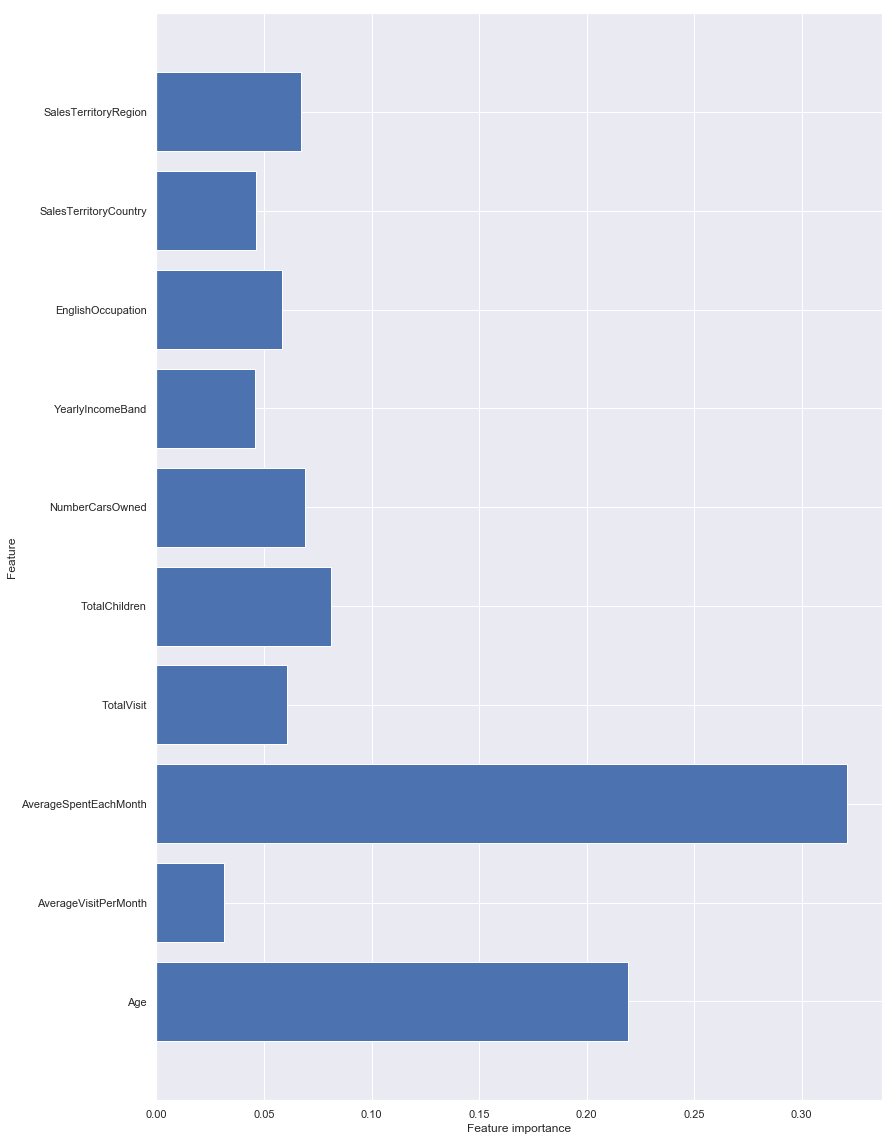

In [66]:

def plot_feature_importances_diabetes(model):
    plt.figure(figsize=(13,20))
    n_features = 10
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), selected_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_diabetes(tree)
plt.savefig('feature_importance')

In [67]:
new_X_train = X_train[features]
new_X_test = X_test[features]

In [68]:
tree = DecisionTreeClassifier(max_depth=3, random_state=10)
tree.fit(new_X_train, y_train)

# predict train set
train_pred=tree.predict(new_X_train)
# predict test set
test_pred=tree.predict(new_X_test)

print("Training set accuracy: {:.3f}".format(accuracy_score(y_train, train_pred)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, test_pred)))

Training set accuracy: 0.555
Test set accuracy: 0.869


In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=2, random_state=10, max_depth=200)
rf.fit(X_train, y_train)

# predict train set
train_pred=rf.predict(X_train)
test_pred=rf.predict(X_test)

print("Training set accuracy: {:.3f}".format(accuracy_score(y_train, train_pred)))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, test_pred,)))

Training set accuracy: 0.833
Test set accuracy: 0.763


In [245]:
clf = RandomForestClassifier(
    n_estimators=2,
    criterion='gini',
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [246]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X_train.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

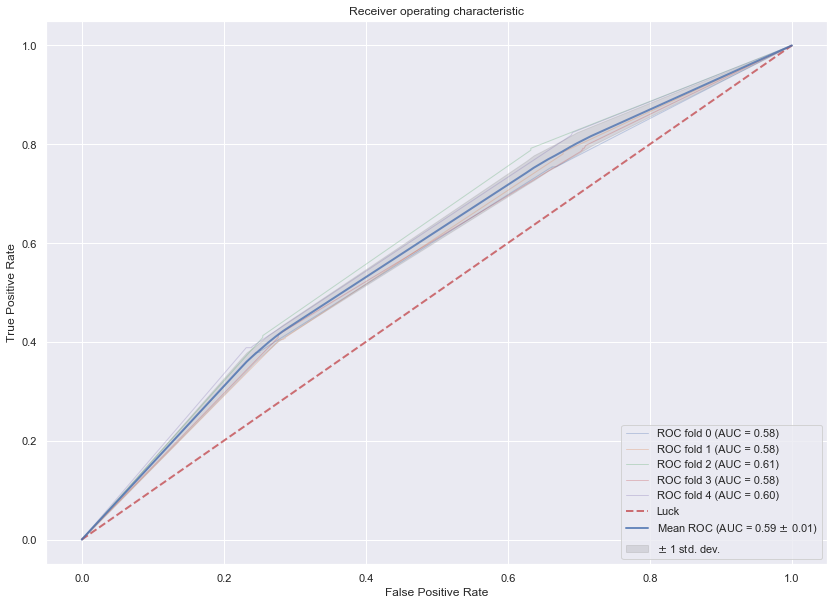

,AUC Train,AUC Test
0,0.920687,0.577668
1,0.921874,0.579654
2,0.925788,0.608073
3,0.924640,0.578642
4,0.923302,0.602922


In [263]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix

cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])



In [273]:

test_pred = clf.predict(X_test).astype(np.int)
print("LIVE DATA ACCURACY: ", accuracy_score(test_pred,y_test))
cmtx = pd.DataFrame(
    confusion_matrix(y_test, test_pred, labels=[1, 0]), 
    index=['true:churned', 'true:not churned'], 
    columns=['pred:churned', 'pred:not churned']
)
print(cmtx)

LIVE DATA ACCURACY:  0.770426515930113
                  pred:churned  pred:not churned
true:churned                 0                 0
true:not churned          1787              5997


In [256]:

result_non_churner_predict = result_non_churner_predict.join(df_yearly_transaction.set_index('CustomerKey'), on='CustomerKey', how='inner')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7784 entries, 7371 to 18483
Data columns (total 29 columns):
CustomerKey              7784 non-null int64
AverageVisitPerMonth     7784 non-null int64
AverageSpentEachMonth    7784 non-null float64
TotalVisit               7784 non-null int64
TotalMonth               7784 non-null int64
Gender                   7784 non-null object
TotalChildren            7784 non-null int64
HouseOwnerFlag           7784 non-null int64
SalesTerritoryRegion     7784 non-null object
SalesTerritoryCountry    7784 non-null object
SalesTerritoryGroup      7784 non-null object
EnglishEducation         7784 non-null object
EnglishOccupation        7784 non-null object
Age                      7784 non-null int64
DateFirstPurchase        7784 non-null object
CommuteDistance          7784 non-null object
NumberCarsOwned          7784 non-null int64
YearlyIncomeBand         7784 non-null object
TotalOrderNumber         7784 non-null int64
TotalSpent             

In [257]:
result_non_churner_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7784 entries, 7371 to 18483
Data columns (total 31 columns):
CustomerKey              7784 non-null int64
AverageVisitPerMonth     7784 non-null int64
AverageSpentEachMonth    7784 non-null float64
TotalVisit               7784 non-null int64
TotalMonth               7784 non-null int64
Gender                   7784 non-null object
TotalChildren            7784 non-null int64
HouseOwnerFlag           7784 non-null int64
SalesTerritoryRegion     7784 non-null object
SalesTerritoryCountry    7784 non-null object
SalesTerritoryGroup      7784 non-null object
EnglishEducation         7784 non-null object
EnglishOccupation        7784 non-null object
Age                      7784 non-null int64
DateFirstPurchase        7784 non-null object
CommuteDistance          7784 non-null object
NumberCarsOwned          7784 non-null int64
YearlyIncomeBand         7784 non-null object
TotalOrderNumber         7784 non-null int64
TotalSpent             

In [250]:
result_non_churner_predict = result_non_churner_predict.fillna(" ")
result_non_churner_predict["FullName"] = result_non_churner_predict.apply(lambda row: " ".join([row["FirstName"],row["MiddleName"],row["Lastname"]]), axis = 1)
final_output= result_non_churner_predict["FullName"].values

In [251]:
output = pd.DataFrame({'Fullname': final_output, 'Churn_prediction': test_pred}, columns=['Fullname', 'Churn_prediction'])

In [260]:
output

,Fullname,Churn_prediction
0,Janelle C Chandra,1
1,Austin Harris,0
2,Faith Hayes,0
3,Brandi Jiménez,0
4,Jamie Harrison,0
5,Adam A Hall,0
6,Spencer P Washington,0
7,Gavin W Bryant,1
8,Chloe R Richardson,0
9,Alan W Sun,0


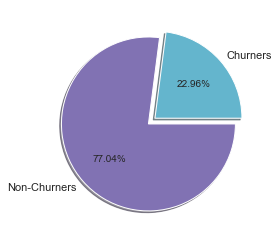

In [253]:
total_data,total_columns = output.shape
#Exploring TARGET_B column
target_non_churners,target_churners=output.groupby('Churn_prediction').size()
pie_slice = [target_churners, target_non_churners]
labels = ['Churners','Non-Churners' ]
colours = ['c','m']
plt.pie(pie_slice,labels=labels,colors=colours,shadow=True,explode=(0.05,0.05), autopct='%1.2f%%')
plt.show()